In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score
from scipy.stats import pearsonr

from util import plot, subject, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
cache = 'default_task'

FG_MASK = get_brainmask()

In [14]:
cachedir = f"results/cache/figurex-isc/{cache}/"
resultdir = f'figures/figure3/{cache}'
!mkdir -p $resultdir
!mkdir -p $cachedir
cachedir

'results/cache/figurex-isc/default_task/'

# entire time series

In [5]:
def get_full_isc():
    iscs = []

    for subA in tqdm(SUBS_STRANGERS):

        dataA = subject.get_bold(subA, cache=cache)

        subB = subject.get_partner(subA)
        dataB = subject.get_bold(subB, cache=cache)

        iscs.append(correlation_score(dataA, dataB))

    sub_mbc = np.stack(iscs)
    
    return sub_mbc

In [6]:
sub_full_isc = get_full_isc()
sub_full_isc.shape

100%|██████████| 58/58 [02:16<00:00,  2.36s/it]


(58, 81924)

In [7]:
# save
with h5py.File(f"{cachedir}/full_isc.hdf5", "w") as f:
    f.create_dataset(name="sub_full_isc", data=sub_full_isc)

In [5]:
# read
with h5py.File(f"{cachedir}/full_isc.hdf5", "r") as f:
    sub_full_isc = f["sub_full_isc"][...]

In [13]:
avg_isc = sub_full_isc.mean(0)

In [14]:
sigmask = stats.ttest_1samp(sub_full_isc, method='fdr_bh', alpha=0.05)
sigmask.sum()

26646

In [15]:
# save
with h5py.File(f"{cachedir}/full_isc_avg.hdf5", "w") as f:
    f.create_dataset(name="avg_isc", data=avg_isc)
    f.create_dataset(name="sigmask", data=sigmask)

In [ ]:
fig = plot.surface_plot(avg_isc, threshold=~sigmask, cmap='Spectral_r')#, vmax=.05)

# prod-comp

In [6]:
def get_mode_isc():
    prod_iscs = []

    for subA in tqdm(SUBS_STRANGERS):

        dataA = subject.get_bold(subA, cache=cache)
        prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)

        subB = subject.get_partner(subA)
        dataB = subject.get_bold(subB, cache=cache)

        prod_mask = prod_boxcar.astype(bool)
        prod_iscs.append(correlation_score(dataA[prod_mask], dataB[prod_mask]))

    sub_prod_isc = np.stack(prod_iscs)
    
    return sub_prod_isc

In [7]:
sub_mode_isc = get_mode_isc()
sub_mode_isc.shape

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [01:28<00:00,  1.53s/it]


(58, 81924)

In [8]:
sigmask = stats.ttest_1samp(sub_mode_isc, method='fdr_bh', alpha=0.05)
sigmask.sum()

14105

In [16]:
# save
with h5py.File(f"{cachedir}/mode_isc.hdf5", "w") as f:
    f.create_dataset(name="sub_mode_isc", data=sub_mode_isc)
    f.create_dataset(name="sigmask", data=sigmask)

In [20]:
# read
with h5py.File(f"{cachedir}/mode_isc.hdf5", "r") as f:
    sub_mode_isc = f["sub_mode_isc"][...]

In [11]:
avg_mode_isc = sub_mode_isc.mean(0)

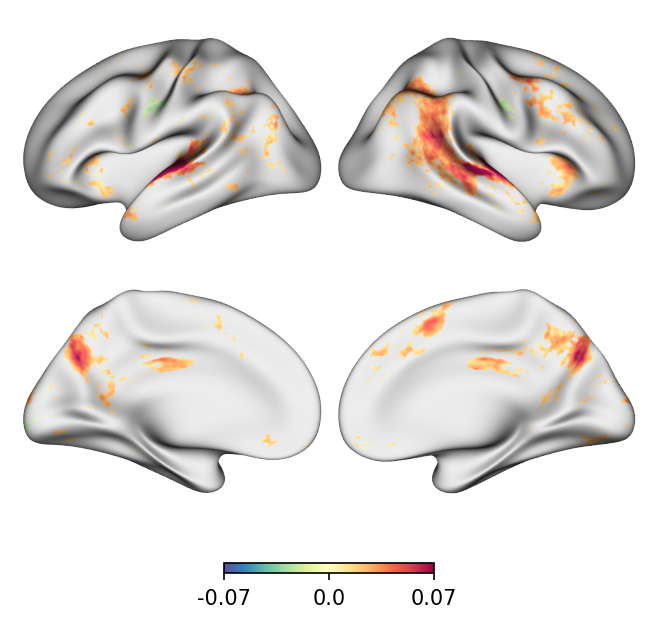

In [15]:
fig = plot.surface_plot(avg_mode_isc, threshold=~sigmask, cmap='Spectral_r')#, vmax=.05)
fig.savefig(f'{resultdir}/isc-prod-comp.svg')

# lagged entire time-series

In [22]:
from scipy.signal import correlate, correlation_lags

In [23]:
def xcorr(
    x: np.ndarray,
    y: np.ndarray,
    mode="full",
    method="fft",
    norm=True,
    maxlags=None,
):
    """General function to compute cross correlation using scipy

    This function will center the data and normalize it by default.
    """

    # Center
    x = x - x.mean()
    y = y - y.mean()

    # Correlate
    corr = correlate(x, y, mode=mode, method=method)
    lags = correlation_lags(x.size, y.size, mode=mode)

    if norm:
        corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is not None:
        middle = (lags == 0).nonzero()[0].item()
        lags = np.arange(-maxlags, maxlags + 1)
        corr = corr[middle - maxlags : middle + maxlags + 1]

    return corr, lags

In [24]:
lags = np.arange(-10, 11)
lags * 1.5

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [25]:
catlas = Atlas.load("custom_glasser_group")
# catlas = Atlas.load("custom_glasser")
# catlas = Atlas.schaefer()
len(catlas)

22

In [ ]:
sub_mbc_scores = []

for subA in tqdm(SUBS_STRANGERS[:29]):

    dataA = subject.get_bold(subA, cache=cache)

    prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
    prod_mask = prod_boxcar.astype(bool)

    subB = subject.get_partner(subA)
    dataB = subject.get_bold(subB, cache=cache)

    dataA = catlas.vox_to_parc(dataA)
    dataB = catlas.vox_to_parc(dataB)

    sub_scores = np.zeros((10, len(lags), dataA.shape[-1]), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        dataA_trial = dataA[trial_slice]
        dataB_trial = dataB[trial_slice]

        for i in range(dataA.shape[-1]):
            corrs, _ = xcorr(dataA_trial[..., i], dataB_trial[..., i], maxlags=len(lags)//2)
            sub_scores[k, :, i] = corrs

        # for i, lag in enumerate(lags):
        #     if lag < 0:
        #         trialA = dataA_trial[:lag]
        #         trialB = dataB_trial[-lag:]
        #     elif lag > 0:
        #         trialA = dataA_trial[lag:]
        #         trialB = dataB_trial[:-lag]
        #     else:
        #         trialA = dataA_trial
        #         trialB = dataB_trial
        #     sub_scores[k, i] = correlation_score(trialA, trialB)

    sub_mbc_scores.append(sub_scores)

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

In [26]:
# ONLY XCORR PROD-COMP CHUNKS

sub_mbc_scores = []

for subA in tqdm(SUBS_STRANGERS):

    dataA = subject.get_bold(subA, cache=cache)
    prod_boxcar, _, _ = subject.get_timinglog_boxcars(subA)
    prod_mask = prod_boxcar.astype(bool)

    subB = subject.get_partner(subA)
    dataB = subject.get_bold(subB, cache=cache)

    dataA = catlas.vox_to_parc(dataA)
    dataB = catlas.vox_to_parc(dataB)

    sub_scores = np.zeros((10, dataA.shape[-1], len(lags)), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        dataA_trial = dataA[trial_slice]
        dataB_trial = dataB[trial_slice]
        pmask_trial = prod_mask[trial_slice]

        all_xcorrs = []
        chunk_bounds = np.diff(pmask_trial, prepend=0).nonzero()[0]
        if pmask_trial.all():
            chunk_bounds = [0, 120]

        if not pmask_trial.any(): # didn't speak at all in this trial
            continue

        for i in range(0, len(chunk_bounds), 2):
            from_idx = chunk_bounds[i] + 1
            to_idx = chunk_bounds[i+1] if i+1 < len(chunk_bounds) else 120

            chunk_size = to_idx - from_idx
            if chunk_size < 7:  # NOTE arbitrary threshold
                continue
            
            # NOTE arbitrary margin
            chunk_slice = slice(max(0, from_idx - 6),
                                min(120, to_idx + 6))

            dataA_chunk = dataA_trial[chunk_slice]
            dataB_chunk = dataB_trial[chunk_slice]

            # loop through each ROI
            roi_xcorrs = []
            for j in range(dataA_chunk.shape[-1]):
                corrs, _ = xcorr(dataA_chunk[..., j],
                                 dataB_chunk[..., j],
                                 maxlags=len(lags)//2)
                roi_xcorrs.append(corrs)
            all_xcorrs.append(roi_xcorrs)

        all_xcorrs = np.stack(all_xcorrs)
        sub_scores[k] = all_xcorrs.mean(0)  # average over chunks

        # print(subA, k, len(chunk_bounds), len(all_xcorrs))
        # print(subA, k, all_xcorrs.shape)

    sub_mbc_scores.append(sub_scores)

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

100%|██████████| 58/58 [00:33<00:00,  1.72it/s]


(58, 10, 22, 21)

In [27]:
# save
with h5py.File(f"{cachedir}/lagged_isc_entire.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [28]:
avg_isc_lags = sub_mbc_prod.mean((0,1)).T  # NOTE transpose
avg_isc_lags.shape

(21, 22)

9 -1
10 0
11 1


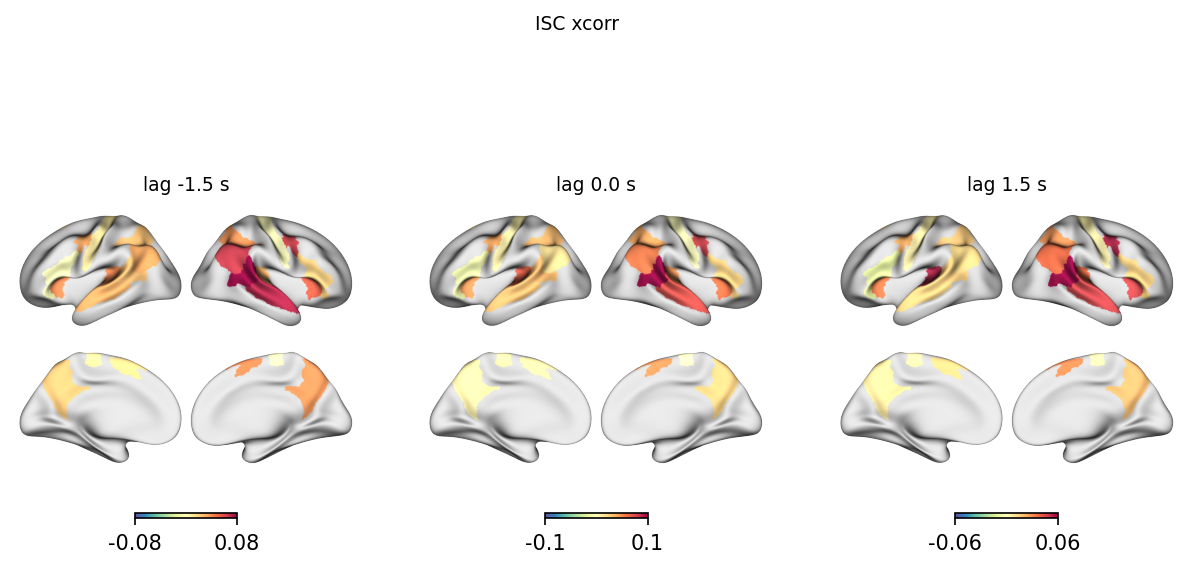

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i, ax in enumerate(axes, start=9):
    print(i, lags[i])
    plot.surface_plot(
        catlas.parc_to_vox(avg_isc_lags[i]),
        cmap="Spectral_r",
        fig=fig,
        ax=ax,
        cbar=True,
        title=f"lag {lags[i]*1.5} s",
    )
fig.suptitle("ISC xcorr")
fig.show()

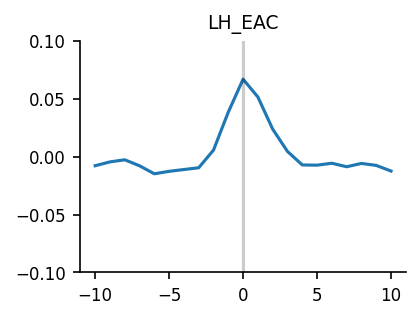

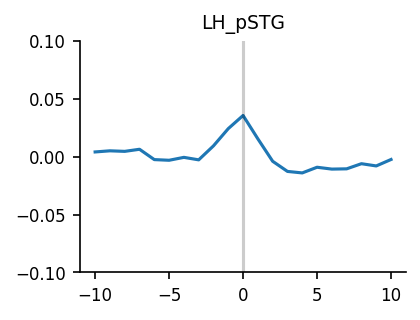

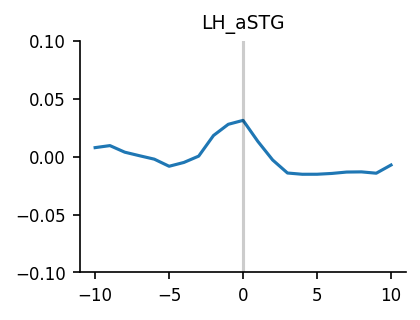

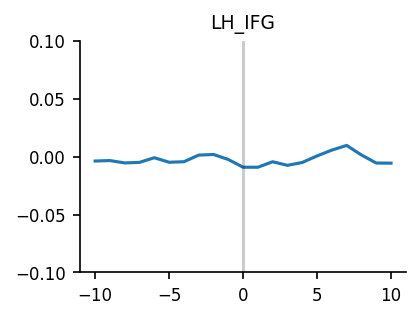

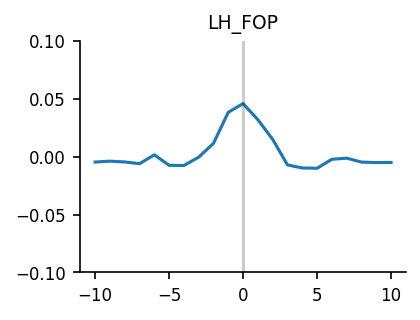

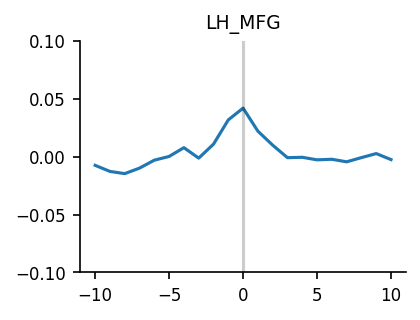

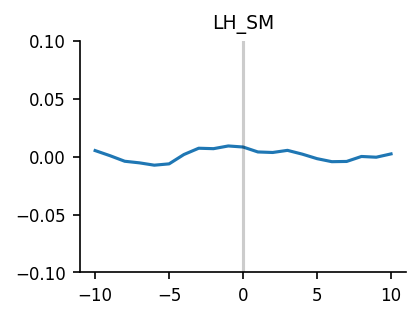

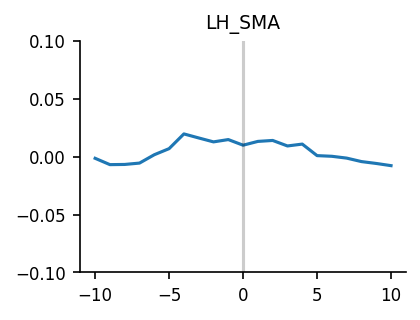

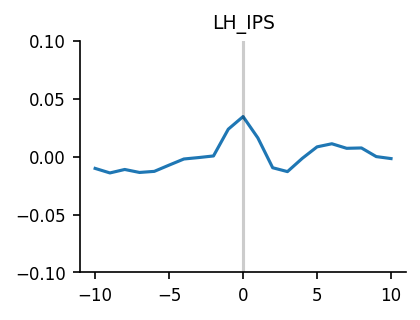

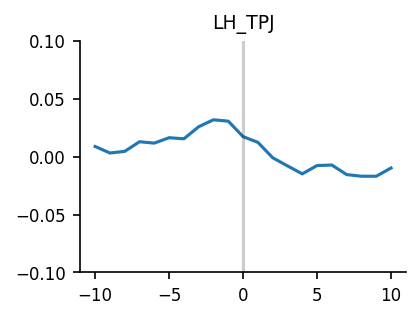

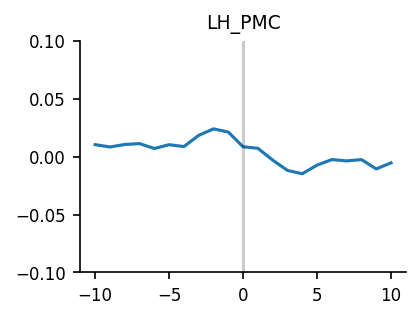

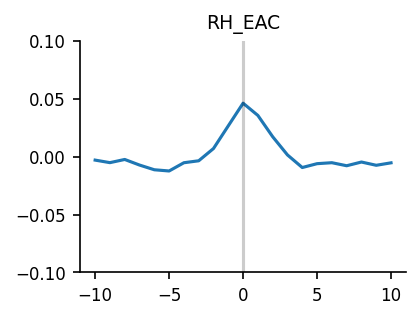

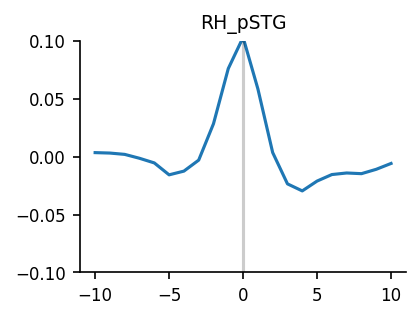

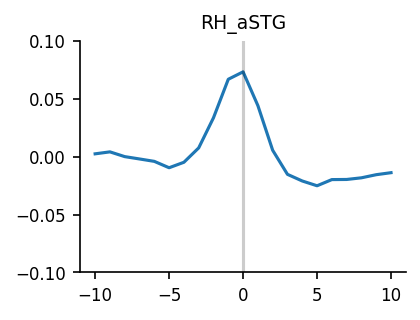

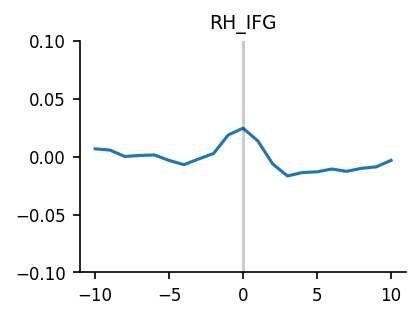

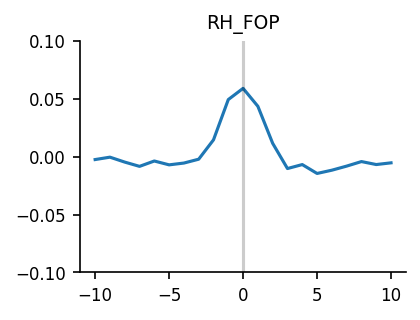

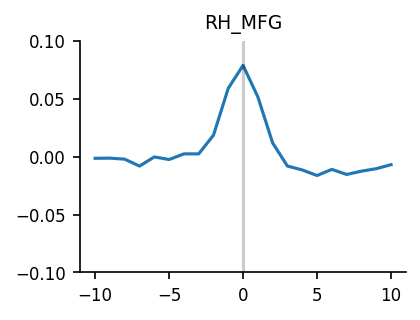

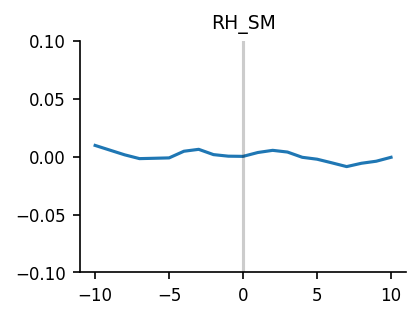

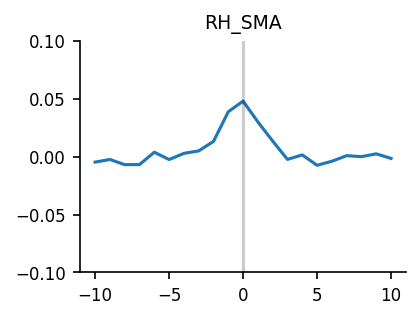

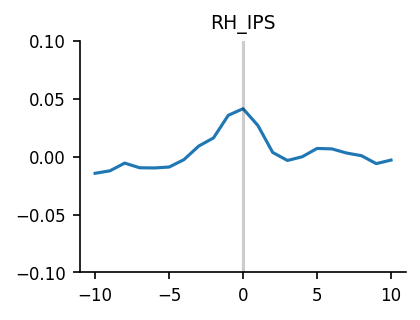

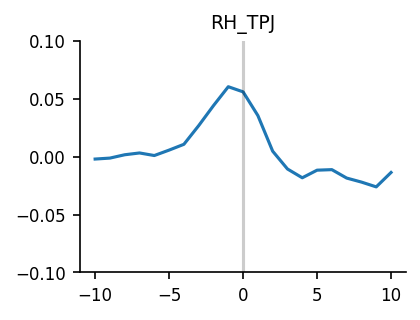

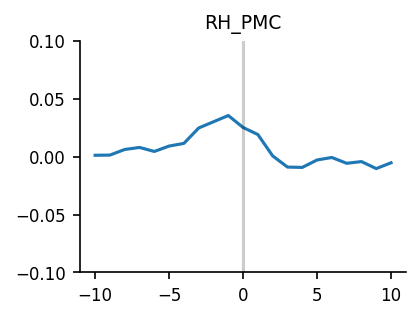

In [30]:
for i, label in enumerate(catlas.labels):
    plt.figure(figsize=(2.8, 2))
    # plt.plot(lags, parcel_lags[:, i])
    plt.plot(lags, avg_isc_lags[:, i])
    plt.axvline(0, alpha=0.2, c='k')
    plt.ylim(-.1, .1)
    plt.title(label)
    plt.show()

In [49]:
parcel_lags = catlas.vox_to_parc(avg_isc_lags)
parcel_lags.shape

(21, 22)

In [ ]:
parcel_id = catlas['17Networks_LH_SomMotB_Aud_1']
parcel_id = catlas['17Networks_LH_DorsAttnA_TempOcc_10']
plt.plot(lags, avg_isc_lags[:, parcel_id])